### Hilbert Diffusion Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from dataset import mnist
from util import (
    get_torch_size_string,
    plot_1xN_torch_img_tensor,
    plot_1xN_torch_traj_tensor,
    hbm_sampler,
    get_hbm_M,
)
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    timestep_embedding,
    forward_sample
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### DDPM constants

[ 0] key:[schedule_name]
[ 1] key:[T]
[ 2] key:[timesteps]
[ 3] key:[betas]
[ 4] key:[alphas]
[ 5] key:[alphas_bar]
[ 6] key:[alphas_bar_prev]
[ 7] key:[sqrt_recip_alphas]
[ 8] key:[sqrt_alphas_bar]
[ 9] key:[sqrt_one_minus_alphas_bar]
[10] key:[posterior_variance]


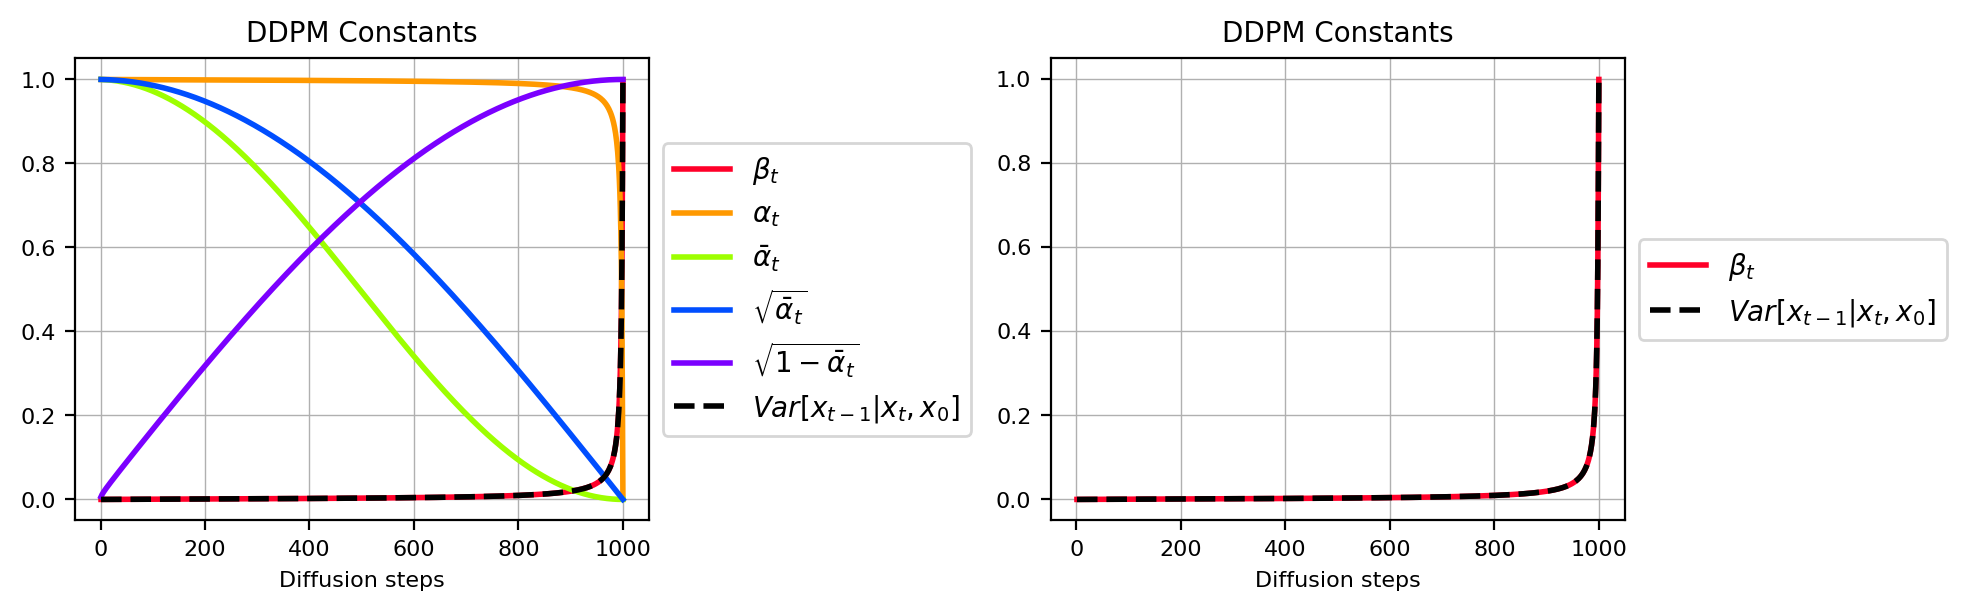

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
for k_idx,key in enumerate(dc.keys()):
    print ("[%2d] key:[%s]"%(k_idx,key))
plot_ddpm_constants(dc)

### Set `device`

In [3]:
device = 'mps'

### Define `Hilbert Brownian Motion`

In [4]:
times = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)) # [L x 1]

In [5]:
M = get_hbm_M(times,hyp_gain=1.0,hyp_len=0.1,device=device)
print ("Hilbert Brownian motion ready.")

Hilbert Brownian motion ready.


### Sample (correlated) noise using `M`

In [6]:
B,C,L = 10,1,100
_,noise = forward_sample(
    x0_batch = th.randn((B,C,L)).to(device),
    t_batch  = th.zeros((B)).to(th.int64).to(device),
    dc       = dc,
    M        = M
) # [B x C x L]

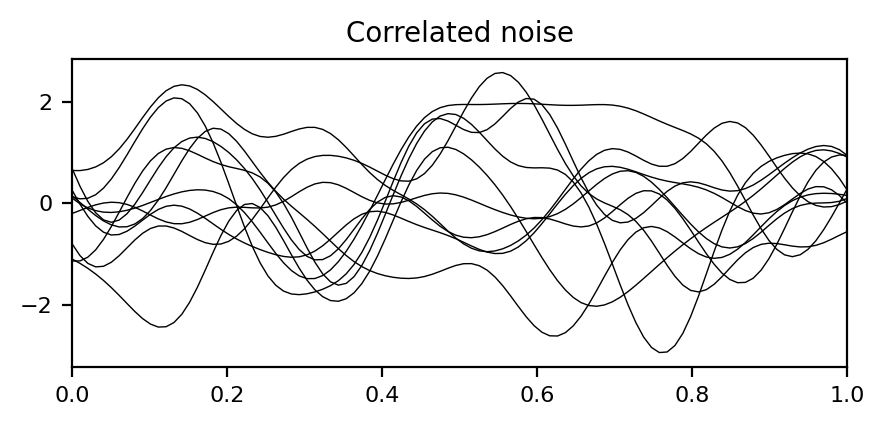

In [7]:
# Plot
plt.figure(figsize=(5,2))
for i_idx in range(B):
    plt.plot(times[:,0],noise.cpu().numpy().squeeze(axis=1)[i_idx,:],
             '-',color='k',lw=1/2)
plt.xlim((0,1))
plt.title('Correlated noise',fontsize=10)
plt.show()

### Forward Diffusion Process

In [8]:
traj = th.from_numpy(
    hbm_sampler(
        times    = times,
        hyp_gain = 2.0,
        hyp_len  = 0.2,
        meas_std = 1e-8,
        n_traj   = 10
    )
).to(th.float32).to(device) # [10 x L]
print ("1D trajectories ready. traj:[%s]"%(get_torch_size_string(traj)))

1D trajectories ready. traj:[10x100]


In [9]:
batch_size = 10
x0_batch = th.tile(
    input = traj[0,:][None,None,:],
    dims  = (batch_size,1,1)).to(device) # [B x C x L]
t_batch = th.linspace(0,dc['T']-1,batch_size).to(th.int64).to(device) # [B]
# Forward diffusion sampling of [B x C x L]
xt_batch,noise = forward_sample(x0_batch,t_batch,dc,M) # [B x C x L]
print ("x0_batch:[%s] t_batch:[%s] => xt_batch:[%s] noise:[%s]"%(
    get_torch_size_string(x0_batch),get_torch_size_string(t_batch),
    get_torch_size_string(xt_batch),get_torch_size_string(noise)))

x0_batch:[10x1x100] t_batch:[10] => xt_batch:[10x1x100] noise:[10x1x100]


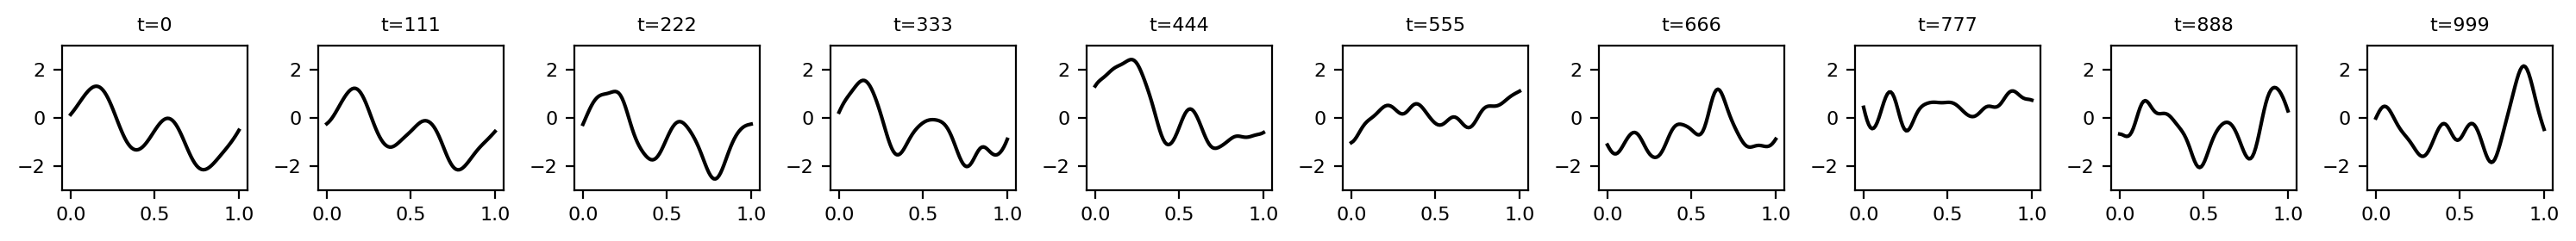

In [17]:
title_str_list = ['t=%d'%(x.cpu().item()) for x in t_batch]
plot_1xN_torch_traj_tensor(times,xt_batch,title_str_list,title_fontsize=8,ylim=[-3,+3],figsize=(15,1.5))